# combine moana and POC & chl etc. to do the PCA

In [1]:
import csv
import os

import cartopy.crs as ccrs
import earthaccess
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import dask.array as da
from   dask.distributed import Client
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import matplotlib
import matplotlib.colors as colors
from matplotlib import lines
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker 
import cartopy.mpl.ticker as cticker
import pandas as pd
from matplotlib.widgets import TextBox
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA



In [2]:
auth = earthaccess.login()

## ROI & date

In [3]:
lon_min = -75
lon_max = 15
lat_min = -30
lat_max = 60
tspan = ("2024-04-01", "2025-07-25")
bbox = (lon_min, lat_min, lon_max, lat_max)

## Gather the data

In [5]:
def time_from_attr(ds):
    """Set the time attribute as a dataset variable

    Args:
        ds: a dataset corresponding to a Level-2 or 3 granule

    Returns:
        the dataset with a scalar "time" coordinate
    """
    datetime = ds.attrs["time_coverage_start"].replace("Z", "")
    ds["time"] = ((), np.datetime64(datetime, "ns"))
    ds = ds.set_coords("time")
    return ds


In [5]:
# POC
results = earthaccess.search_data(
    short_name="PACE_OCI_L3M_POC",
    temporal=tspan,
    bounding_box=bbox,
    granule_name="*.DAY.*.0p1deg.*",
)
paths = earthaccess.open(results)
kwargs = {"combine": "nested", "concat_dim": "time"}
prod = xr.open_mfdataset(paths, preprocess=time_from_attr, **kwargs)
dataset_POC = prod


KeyboardInterrupt: 

In [6]:
# dataset_POC
dataset_POC = dataset_POC.sel(lon=slice(lon_min,lon_max), lat=slice(lat_max,lat_min)).drop_vars("palette")
POC_mon_mean = dataset_POC['poc'].groupby("time.month").mean()

In [7]:
# POC_mon_mean.to_netcdf("POC_monthly_mean.nc")

In [8]:
# Chl
results = earthaccess.search_data(
    short_name="PACE_OCI_L3M_CHL",
    temporal=tspan,
    bounding_box=bbox,
    granule_name="*.DAY.*.0p1deg.*",
)
paths = earthaccess.open(results)
prod = xr.open_mfdataset(paths, preprocess=time_from_attr, **kwargs)
dataset_chl = prod
dataset_chl

QUEUEING TASKS | :   0%|          | 0/387 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/387 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/387 [00:00<?, ?it/s]

<xarray.Dataset> Size: 10GB
Dimensions:  (time: 387, lat: 1800, lon: 3600, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 7kB 89.95 89.85 89.75 89.65 ... -89.75 -89.85 -89.95
  * lon      (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
  * time     (time) datetime64[ns] 3kB 2024-03-31T23:33:05 ... 2025-05-01T23:...
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    chlor_a  (time, lat, lon) float32 10GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    palette  (time, rgb, eightbitcolor) uint8 297kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/64)
    product_name:                      PACE_OCI.20240401.L3m.DAY.CHL.V3_0.chl...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/CHL/3.0
    keywords:                          Earth Science > Oceans > Ocean Chemist...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         555432
    data_minimum:                      0.005920372
    data_maximum:                      90.442894

In [9]:
dataset_chl    = dataset_chl.sel(lon=slice(lon_min,lon_max), lat=slice(lat_max,lat_min)).drop_vars("palette")
CHL_mon_mean = dataset_chl["chlor_a"].groupby("time.month").mean()
# CHL_mon_mean.to_netcdf("CHL_monthly_mean.nc")

In [11]:
# cphyto
results_cphyto = earthaccess.search_data(
    short_name="PACE_OCI_L3M_CARBON",
    temporal=tspan,
    bounding_box=bbox,
    granule_name="*.DAY.*.0p1deg.*",
)
paths = earthaccess.open(results_cphyto)
prod = xr.open_mfdataset(paths, preprocess=time_from_attr, **kwargs)
dataset_cphyto = prod
dataset_cphyto

QUEUEING TASKS | :   0%|          | 0/387 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/387 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/387 [00:00<?, ?it/s]

<xarray.Dataset> Size: 10GB
Dimensions:       (time: 387, lat: 1800, lon: 3600, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat           (lat) float32 7kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * lon           (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
  * time          (time) datetime64[ns] 3kB 2024-03-31T23:33:05 ... 2025-05-0...
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    carbon_phyto  (time, lat, lon) float32 10GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    palette       (time, rgb, eightbitcolor) uint8 297kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/62)
    product_name:                      PACE_OCI.20240401.L3m.DAY.CARBON.V3_0....
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    cdm_data_type:                     grid
    identifier_product_doi_authority:  http://dx.doi.org
    identifier_product_doi:            10.5067/PACE/OCI/L3M/CARBON/3.0
    data_bins:                         554626
    data_minimum:                      0.59064007
    data_maximum:                      1000.0002

In [14]:
dataset_cphyto    = dataset_cphyto.sel(lon=slice(lon_min,lon_max), lat=slice(lat_max,lat_min))
cphyto_mon_mean = dataset_cphyto["carbon_phyto"].groupby("time.month").mean()
# cphyto_mon_mean.to_netcdf("cphyto_monthly_mean.nc")

In [6]:
# moana
results_moana = earthaccess.search_data(
    short_name="PACE_OCI_L3M_MOANA",
    temporal=tspan,
    bounding_box=bbox,
    granule_name="*.DAY.*.0p1deg.*",
)
paths = earthaccess.open(results_moana)
kwargs = {"combine": "nested", "concat_dim": "time"}
prod = xr.open_mfdataset(paths, preprocess=time_from_attr, **kwargs)
dataset_moana = prod
dataset_moana

QUEUEING TASKS | :   0%|          | 0/376 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/376 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/376 [00:00<?, ?it/s]

<xarray.Dataset> Size: 7GB
Dimensions:          (time: 376, lat: 1400, lon: 1100, rgb: 3,
                      eightbitcolor: 256)
Coordinates:
  * lat              (lat) float32 6kB 69.95 69.85 69.75 ... -69.85 -69.95
  * lon              (lon) float32 4kB -84.95 -84.85 -84.75 ... 24.85 24.95
  * time             (time) datetime64[ns] 3kB 2024-04-01T11:01:27 ... 2025-0...
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    prococcus_moana  (time, lat, lon) float32 2GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    syncoccus_moana  (time, lat, lon) float32 2GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    picoeuk_moana    (time, lat, lon) float32 2GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    palette          (time, rgb, eightbitcolor) uint8 289kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/62)
    product_name:                      PACE_OCI.20240401.L3m.DAY.MOANA.V3_0.0...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    cdm_data_type:                     grid
    identifier_product_doi_authority:  http://dx.doi.org
    identifier_product_doi:            10.5067/PACE/OCI/L3M/MOANA/3.0
    data_bins:                         166600
    data_minimum:                      -inf
    data_maximum:                      inf

In [11]:
dataset_moana  = dataset_moana.sel(lon=slice(lon_min,lon_max), lat=slice(lat_max,lat_min))#.drop_vars("palette")
moana_mon_mean = dataset_moana.groupby("time.month").mean()
# moana_reindex  = moana_mon_mean.reindex_like(Cphyto_mon_mean, method="nearest")
moana_mon_mean.to_netcdf("moana_monthly_mean_new.nc")

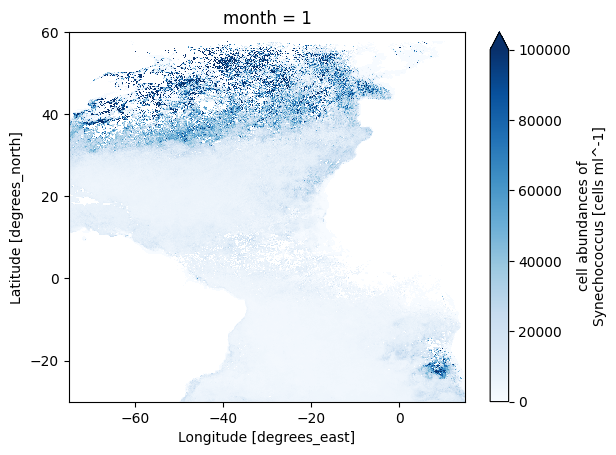

/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [9]:
moana_mon_mean.syncoccus_moana[0].plot.imshow(cmap='Blues', vmin=0, vmax=1E5)

In [8]:
# select roi
dataset_cphyto = dataset_cphyto.sel(lon=slice(lon_min,lon_max), lat=slice(lat_max,lat_min)).drop_vars("palette")
dataset_chl    = dataset_chl.sel(lon=slice(lon_min,lon_max), lat=slice(lat_max,lat_min)).drop_vars("palette")
dataset_POC    = dataset_POC.sel(lon=slice(lon_min,lon_max), lat=slice(lat_max,lat_min)).drop_vars("palette")
dataset_moana  = dataset_moana.sel(lon=slice(lon_min,lon_max), lat=slice(lat_max,lat_min)).drop_vars("palette")



## Monthly mean before merge dataArray together

In [9]:
# get monthly mean
POC_mon_mean = dataset_POC['poc'].groupby("time.month").mean()
CHL_mon_mean = dataset_chl["chlor_a"].groupby("time.month").mean()
Cphyto_mon_mean = dataset_cphyto["carbon_phyto"].groupby("time.month").mean()
moana_mon_mean  = dataset_moana.groupby("time.month").mean()

# reindex
moana_reindex = moana_mon_mean.reindex_like(Cphyto_mon_mean, method="nearest")

In [10]:
ds_merge = xr.merge([POC_mon_mean, CHL_mon_mean, Cphyto_mon_mean, moana_reindex], compat='override')

In [13]:
# ds_merge.to_netcdf("GroupProject/phytoSTEW/Team/Zichang/PCC_BGC_monthly_mean_merged.nc")

PermissionError: [Errno 13] Permission denied: '/home/jovyan/GroupProject/phytoSTEW/Team/Zichang/GroupProject/phytoSTEW/Team/Zichang/PCC_BGC_monthly_mean_merged.nc'

### Read in SST

In [35]:
collection_short_name = "MUR25-JPL-L4-GLOB-v04.2"

# Search granules
results = earthaccess.search_data(
    short_name=collection_short_name,
    temporal=tspan,
    bounding_box=bbox
)

print(f"Found {len(results)} granules")

Found 452 granules


In [37]:
ghrsst = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/452 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/452 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/452 [00:00<?, ?it/s]

In [ ]:
#Monthly mean composites
ds = xr.open_mfdataset(
    ghrsst,
    engine="h5netcdf",
    combine="by_coords",
    drop_variables=["mask", "sea_ice_fraction", "dt_1km_data", "sst_anomaly", "analysis_error"]
)

# Compute SST in Atlantic region and convert from Kelvin to Celsius
sst = ds['analysed_sst'].sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max)) - 273.15

sst_mon_mean = sst.groupby('time.month').mean(dim='time', skipna=True)
